In [8]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [66]:
from Preprocessing.preprocessing import match
from tqdm import tqdm

##### Warning: two stage preprocessing must have been carried out to successfully run this notebook (see *preprocessing-pipeline.ipynb*)

In [2]:
preprocessed_data_path = 'Processed_data/'
two_stage_folder = preprocessed_data_path+'two_stage/'
stage_1_folder = two_stage_folder+'stage_1/'
stage_2_folder = two_stage_folder+'stage_2/'

### Stage 1:

First, let's load stage 1 data

In [4]:
# filenames
X_train_stage1_filename = "X_train_stage1.pkl"
y_train_stage1_filename = "y_train_stage1.pkl"

X_test_stage1_filename = "X_test_stage1.pkl"
y_test_stage1_filename = "y_test_stage1.pkl"

# load data
X_train_stage1 = pd.read_pickle(stage_1_folder+X_train_stage1_filename)
y_train_stage1 = pd.read_pickle(stage_1_folder+y_train_stage1_filename)

X_test_stage1 = pd.read_pickle(stage_1_folder+X_test_stage1_filename)
y_test_stage1 = pd.read_pickle(stage_1_folder+y_test_stage1_filename)

Then one uses gradient boosting technique to classify 'HFT' and 'NON-HFT' traders.

In [7]:
clf = lgb.LGBMClassifier(boosting_type='gbdt')
clf.fit(X_train_stage1, y_train_stage1)

LGBMClassifier()

Now, let's compare train and test set accuracy

In [12]:
print('Training set score: {:.4f}'.format(clf.score(X_train_stage1, y_train_stage1)))

print('Test set score: {:.4f}'.format(clf.score(X_test_stage1, y_test_stage1)))

Training set score: 1.0000
Test set score: 0.9995


Plot confusion matrix

In [15]:
y_pred=clf.predict(X_test_stage1)
cm = confusion_matrix(y_test_stage1, y_pred)
cm

array([[2642,    2],
       [   2, 6147]])

<AxesSubplot:>

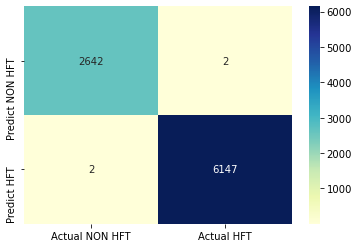

In [17]:
cm_matrix = pd.DataFrame(data=cm, columns=['Actual NON HFT', 'Actual HFT'], 
                                 index=['Predict NON HFT', 'Predict HFT'])

sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu')

In [37]:
set(y_pred)

{0, 2}

### Stage 2:

In [18]:
# filenames
X_train_stage2_filename = "X_train_stage2.pkl"
y_train_stage2_filename = "y_train_stage2.pkl"

X_test_stage2_filename = "X_test_stage2.pkl"
y_test_stage2_filename = "y_test_stage2.pkl"

# load data
X_train_stage2 = pd.read_pickle(stage_2_folder+X_train_stage2_filename)
y_train_stage2 = pd.read_pickle(stage_2_folder+y_train_stage2_filename)

X_test_stage2 = pd.read_pickle(stage_2_folder+X_test_stage2_filename)
y_test_stage2 = pd.read_pickle(stage_2_folder+y_test_stage2_filename)

In [34]:
if(X_train_stage2['type'].dtype == 'O'):
    X_train_stage2['type'] = X_train_stage2['type'].apply(match)

if(X_test_stage2['type'].dtype == 'O'):
    X_test_stage2['type'] = X_test_stage2['type'].apply(match)

dtype('int64')

Let's make a vote on the train set, using previously trained classifier

In [94]:
def deduce_type_from_vote(score, lower_bound=0.05, upper_bound=0.95):
    '''
    score: average of predicted type values
        over all rows of one trader's block
    lower_bound: if HFT percentage is lower than this bound, trader
        will be classified as NON-HFT
    upper_bound: if HFT percentage is bigger than this bound, trader
        will be classified as HFT
    '''
    
    HFT = 2
    if(score < lower_bound * HFT):
        return 0
    elif(score < upper_bound * HFT):
        return 1
    else:
        return 2

In [79]:
def zero_one_loss(cm):
    '''
    cm: confusion matrix
    
    returns the number of misclassified traders
    '''
    return np.sum(cm) - np.trace(cm)

In [126]:
def compute_cm_s2(X, lower_bound, upper_bound, stage1_m):
    '''
    X: traders data
    lower_bound, upper_bound: parameters of deduce_type_from_vote
    stage1_m: model trained at stage 1
    
    computes the confusion matrix, after a vote using stage 1 model on
    each line of X
    '''
    traders = list(set(X['Trader']))
    
    cm = np.zeros((3,3))

    for trader in traders:
        # isolate data related to one trader
        trader_block = X[X['Trader'] == trader]
        real_type = trader_block['type'].iloc[0] 

        # drop columns so as to use the stage 1 model
        trader_block.drop('Trader', axis=1, inplace=True)
        trader_block.drop('type', axis=1, inplace=True)

        # predict types using a vote
        pred_type_lines = stage1_m.predict(trader_block)
        score = np.mean(pred_type_lines)
        pred_type = deduce_type_from_vote(score, lower_bound=lower_bound,
                                          upper_bound=upper_bound)

        cm[real_type][pred_type] += 1

    return cm

We will use a grid search to optimize 'lower_bound' and 'upper_bound' parameters

In [103]:
def grid_search(X, stage1_m, max_NON_HFT_bound=0.1, min_HFT_bound=0.9, num=10):
    '''
    X: traders data
    max_NON_HFT_bound, min_HFT_bound: bounds for the grid search
    num: number of points on each axis of the grid
    stage1_m: model trained at stage 1
    
    grid search to optimize the bounds used by deduce_type_from_vote
    '''
    
    # define the grid
    NON_HFT_bounds = np.linspace(0., max_NON_HFT_bound, num=num)
    HFT_bounds = np.linspace(min_HFT_bound, 1., num=num)
    
    opt_bounds = np.zeros(2)
    min_loss = len(set(X['Trader'])) + 1 # total number of traders
    
    for non_hft_b in tqdm(NON_HFT_bounds):
        for hft_b in HFT_bounds:
            cm = compute_cm_s2(X, non_hft_b, hft_b, stage1_m)
            loss = zero_one_loss(cm)
            if(loss < min_loss):
                opt_bounds[0], opt_bounds[1] = non_hft_b, hft_b
                min_loss = loss
    
    return opt_bounds


In [104]:
opt_low, opt_up = grid_search(X_train_stage2, clf, num=15)

100%|██████████| 15/15 [00:38<00:00,  2.60s/it]


In [105]:
print(opt_low, opt_up)

0.014285714285714287 1.0


In [107]:
cm = compute_cm_s2(X_train_stage2, opt_low, opt_up, clf)
print("Training loss:", zero_one_loss(cm)/np.sum(cm))

Training loss: 0.20833333333333334


Apply on test set

In [110]:
cm_test = compute_cm_s2(X_test_stage2, opt_low, opt_up, clf)
print("Test loss:", zero_one_loss(cm_test)/np.sum(cm_test))

Test loss: 0.0


### Build a prediction

In [137]:
from TestingPipeline.TestModel import *

Stage 1 training

In [98]:
X_s1 = X_train_stage1.append(X_test_stage1, ignore_index=True)
y_s1 = y_train_stage1.append(y_test_stage1, ignore_index=True)

In [113]:
clf_final = lgb.LGBMClassifier(boosting_type='gbdt')
clf_final.fit(X_s1, y_s1)

LGBMClassifier()

In [114]:
print('Training set score: {:.4f}'.format(clf_final.score(X_s1, y_s1)))

Training set score: 1.0000


Stage 2 training

In [115]:
X_s2 = X_train_stage2.append(X_test_stage2, ignore_index=True)
y_s2 = y_train_stage2.append(y_test_stage2, ignore_index=True)

In [116]:
opt_low_final, opt_up_final = grid_search(X_s2, clf_final, num=15)

100%|██████████| 15/15 [01:12<00:00,  4.82s/it]


In [148]:
print(opt_low_final, opt_up_final)

0.014285714285714287 1.0


In [117]:
cm = compute_cm_s2(X_s2, opt_low_final, opt_up_final, clf_final)
print("Training loss:", zero_one_loss(cm)/np.sum(cm))

Training loss: 0.14285714285714285


In [121]:
X_test = pd.read_csv('Processed_data/X_test_preprocessed.csv')

In [125]:
X_s2.shape[1]

20

In [123]:
X_test.columns.shape

(19,)

In [127]:
def match_inv(x):
    if x == 0:
        return 'NON HFT'
    elif x == 1:
        return 'MIX'
    elif x == 2:
        return 'HFT'
    else:
        return 'WTF'

In [130]:
def predict_label(X_test, lower_bound, upper_bound, stage1_m):
    '''
    X_test: traders test data
    lower_bound, upper_bound: parameters of deduce_type_from_vote
    stage1_m: model trained at stage 1
    
    returns the predicted type label for each trader
    '''
    traders = list(set(X_test['Trader']))
    
    pred_traders = {}
    cm = np.zeros((3,3))

    for trader in traders:
        # isolate data related to one trader
        trader_block = X_test[X_test['Trader'] == trader]

        # drop columns so as to use the stage 1 model
        trader_block.drop('Trader', axis=1, inplace=True)

        # predict types using a vote
        pred_type_lines = stage1_m.predict(trader_block)
        score = np.mean(pred_type_lines)
        pred_type = deduce_type_from_vote(score, lower_bound=lower_bound,
                                          upper_bound=upper_bound)
        
        pred_traders[trader] = match_inv(pred_type)
        
    return pred_traders

In [131]:
y_pred = predict_label(X_test, opt_low_final, opt_up_final, clf_final)

In [139]:
help(y_pred)

Help on dict object:

class dict(object)
 |  dict() -> new empty dictionary
 |  dict(mapping) -> new dictionary initialized from a mapping object's
 |      (key, value) pairs
 |  dict(iterable) -> new dictionary initialized as if via:
 |      d = {}
 |      for k, v in iterable:
 |          d[k] = v
 |  dict(**kwargs) -> new dictionary initialized with the name=value pairs
 |      in the keyword argument list.  For example:  dict(one=1, two=2)
 |  
 |  Built-in subclasses:
 |      StgDict
 |  
 |  Methods defined here:
 |  
 |  __contains__(self, key, /)
 |      True if the dictionary has the specified key, else False.
 |  
 |  __delitem__(self, key, /)
 |      Delete self[key].
 |  
 |  __eq__(self, value, /)
 |      Return self==value.
 |  
 |  __ge__(self, value, /)
 |      Return self>=value.
 |  
 |  __getattribute__(self, name, /)
 |      Return getattr(self, name).
 |  
 |  __getitem__(...)
 |      x.__getitem__(y) <==> x[y]
 |  
 |  __gt__(self, value, /)
 |      Return self>va

In [140]:
y_pred.values()

dict_values(['HFT', 'HFT', 'NON HFT', 'HFT', 'MIX', 'NON HFT', 'MIX', 'MIX', 'MIX', 'MIX', 'MIX', 'MIX', 'NON HFT', 'NON HFT', 'MIX', 'NON HFT', 'NON HFT', 'NON HFT', 'MIX', 'MIX', 'MIX', 'NON HFT', 'MIX', 'NON HFT', 'NON HFT', 'MIX', 'MIX', 'NON HFT', 'MIX', 'MIX', 'MIX', 'NON HFT', 'NON HFT', 'MIX', 'MIX', 'NON HFT', 'MIX', 'MIX', 'NON HFT', 'MIX', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'MIX', 'MIX', 'MIX', 'MIX', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'HFT', 'MIX', 'MIX', 'HFT', 'NON HFT', 'NON HFT', 'HFT', 'MIX', 'NON HFT', 'NON HFT', 'NON HFT', 'MIX', 'NON HFT', 'NON HFT', 'NON HFT', 'NON HFT', 'MIX', 'MIX', 'MIX', 'MIX', 'MIX', 'HFT', 'NON HFT', 'HFT'])

In [145]:
pred = pd.DataFrame()
pred['Trader'] = y_pred.keys()
pred['type'] = y_pred.values()
pred.head()

,Trader,type
0,The Doorman,HFT
1,Alice,HFT
2,Dr. Delbert Doppler,NON HFT
3,Brudo Avarius,HFT
4,Dr. Facilier,MIX


In [147]:
pred.to_csv('Prediction/pred_two_stage.csv', index =False)